In [15]:
import os
import networkx as nx
import datetime
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from nestedness_calculator import NestednessCalculator
import csv


In [16]:
#!pip install cugraph
# import cugraph as cnx

In [17]:
path = "graphs/nodes_hashtag/"
MANIFESTACION = "nat"
    

In [18]:
def calc_nestedness1(G):
    matrix = nx.to_numpy_array(G)
    rows, cols = matrix.shape

    posiciones_1 = np.array([np.where(matrix[i] == 1)[0] for i in range(rows)])

    ones_rows = np.sum(matrix == 1, axis=1)
    ones_rows = np.sum(matrix == 1, axis=0)
    cum_n_ij = 0
    # NODF por filas
    for i in tqdm(range(rows)):
        for j in range(i+1, rows):
            if ones_rows[i] < ones_rows[j]:
                # df = 100
                continue
            else:
                # df = 0
                # Calculo PO
                
                # Identificar las posiciones de los unos en la fila i y j
                posiciones_1_i = posiciones_1[i]
                posiciones_1_j = posiciones_1[j]
                
                # Contar cuántas posiciones de unos en j coinciden con las de i
                coincidencias = np.in1d(posiciones_1_j, posiciones_1_i).sum()      

                # Calcular el porcentaje de coincidencias, PO
                n_ij = (coincidencias / len(posiciones_1_j)) * 100 if len(posiciones_1_j) > 0 else 0
                cum_n_ij += n_ij  

        # NODF por columnas
    

    mod_rows = (rows*(rows-1))/2
    mod_cols = (cols*(cols-1))/2
    den = mod_rows + mod_cols
    nodf = cum_n_ij/den
    return nodf

In [19]:
def calc_nestedness(G):
    mat = nx.to_numpy_array(G, weight=None)
    mat = mat[~np.all(mat == 0, axis=1)]
    mat = mat[:,~np.all(mat == 0, axis=0)]
    nodf_score = NestednessCalculator(mat).nodf(mat)
    return nodf_score

In [20]:
dict_file = {}
with open("data/files/" + MANIFESTACION + ".csv", "r") as file:
   reader = csv.DictReader(file)
   for row in reader:
       dict_file[row["hour"]] = row

In [21]:
direct = path + MANIFESTACION + '/'
arr_clust = []
arr_hour = []
arr_mod = []
arr_nest = []
   
with open("data/files/" + MANIFESTACION + ".csv", "a") as file:
   writer = csv.DictWriter(file, fieldnames=["hour", "nestedness", "modularity", "clusterization"])
   for root, dirs, files in os.walk(direct, topdown=False):
      for name in tqdm(files):
         if name.endswith(".gexf"):
               hora = name[:-5]
               arr_hour.append(hora)
               print("Analizando grafo", hora)
               if not hora in dict_file.keys():
                  G = nx.read_gexf(direct + name)
                  nestedness = calc_nestedness(G)
                  arr_nest.append(nestedness)
                  avg_clust=nx.average_clustering(G)
                  arr_clust.append(avg_clust)
                  modularity_louv = nx.community.modularity(G, nx.community.louvain_communities(G, seed=123))
                  arr_mod.append(modularity_louv)
                  writer.writerow({'hour': hora, 'nestedness': nestedness, 'clusterization': avg_clust, 'modularity': modularity_louv})
               #print("Analizado grafo", name[:-5], "coef_avg_clust:", round(avg_clust, 6), "coef_mod:", round(modularity_louv, 6))
               else:
                  print(hora, "ya está guardado")
                  arr_nest.append(float(dict_file[hora]["nestedness"]))
                  arr_clust.append(float(dict_file[hora]["clusterization"]))
                  arr_mod.append(float(dict_file[hora]["modularity"]))


100%|██████████| 97/97 [00:00<00:00, 14998.99it/s]

Analizando grafo 437010
437010 ya está guardado
Analizando grafo 437015
437015 ya está guardado
Analizando grafo 437069
437069 ya está guardado
Analizando grafo 437011
437011 ya está guardado
Analizando grafo 437019
437019 ya está guardado
Analizando grafo 437048
437048 ya está guardado
Analizando grafo 437070
437070 ya está guardado
Analizando grafo 437018
437018 ya está guardado
Analizando grafo 437067
437067 ya está guardado
Analizando grafo 437022
437022 ya está guardado
Analizando grafo 437058
437058 ya está guardado
Analizando grafo 437025
437025 ya está guardado
Analizando grafo 437034
437034 ya está guardado
Analizando grafo 437044
437044 ya está guardado
Analizando grafo 437028
437028 ya está guardado
Analizando grafo 437036
437036 ya está guardado
Analizando grafo 437068
437068 ya está guardado
Analizando grafo 437038
437038 ya está guardado
Analizando grafo 437030
437030 ya está guardado
Analizando grafo 437009
437009 ya está guardado
Analizando grafo 437056
437056 ya está g

In [22]:
data = list(zip(arr_hour, arr_clust, arr_mod, arr_nest))
data.sort()
hour_sort, clust_sort, mod_sort, nest_sort = zip(*data)
hour_sort = list(hour_sort)
clust_sort = list(clust_sort)
mod_sort = list(mod_sort)
nest_sort = list(nest_sort)

In [23]:
dt_sort_arr=[]
for hour in hour_sort:
    dt_sort_arr.append(datetime.datetime.fromtimestamp(int(hour)*3600))
print(MANIFESTACION, ", hora con avg_clust max", dt_sort_arr[clust_sort.index(max(clust_sort))], "hour_name:", hour_sort[clust_sort.index(max(clust_sort))])
print(MANIFESTACION, ", hora con avg_clust min", dt_sort_arr[clust_sort.index(min(clust_sort))], "hour_name:", hour_sort[clust_sort.index(min(clust_sort))])

print(MANIFESTACION, ", hora con modularity max", dt_sort_arr[mod_sort.index(max(mod_sort))], "hour_name:", hour_sort[mod_sort.index(max(mod_sort))])
print(MANIFESTACION, ", hora con modularity min", dt_sort_arr[mod_sort.index(min(mod_sort))], "hour_name:", hour_sort[mod_sort.index(min(mod_sort))])

print(MANIFESTACION, ", hora con nestedness max", dt_sort_arr[nest_sort.index(max(nest_sort))], "hour_name:", hour_sort[nest_sort.index(max(nest_sort))])
print(MANIFESTACION, ", hora con nestedness min", dt_sort_arr[nest_sort.index(min(nest_sort))], "hour_name:", hour_sort[nest_sort.index(min(nest_sort))])

9n , hora con avg_clust max 2019-11-08 15:00:00 hour_name: 437006
9n , hora con avg_clust min 2019-11-09 21:00:00 hour_name: 437036
9n , hora con modularity max 2019-11-10 01:00:00 hour_name: 437040
9n , hora con modularity min 2019-11-10 04:00:00 hour_name: 437043
9n , hora con nestedness max 2019-11-10 01:00:00 hour_name: 437040
9n , hora con nestedness min 2019-11-08 17:00:00 hour_name: 437008


['436983', '436984', '436985', '436986', '436987', '436988', '436989', '436990', '436991', '436992', '436993', '436994', '436995', '436996', '436997', '436998', '436999', '437000', '437001', '437002', '437003', '437004', '437005', '437006', '437007', '437008', '437009', '437010', '437011', '437012', '437013', '437014', '437015', '437016', '437017', '437018', '437019', '437020', '437021', '437022', '437023', '437024', '437025', '437026', '437027', '437028', '437029', '437030', '437031', '437032', '437033', '437034', '437035', '437036', '437037', '437038', '437039', '437040', '437041', '437042', '437043', '437044', '437045', '437046', '437047', '437048', '437049', '437050', '437051', '437052', '437053', '437054', '437055', '437056', '437057', '437058', '437059', '437060', '437061', '437062', '437063', '437064', '437065', '437066', '437067', '437068', '437069', '437070', '437071', '437072', '437073', '437074', '437075', '437076', '437077', '437078', '437079']
Fecha identificada en paper p

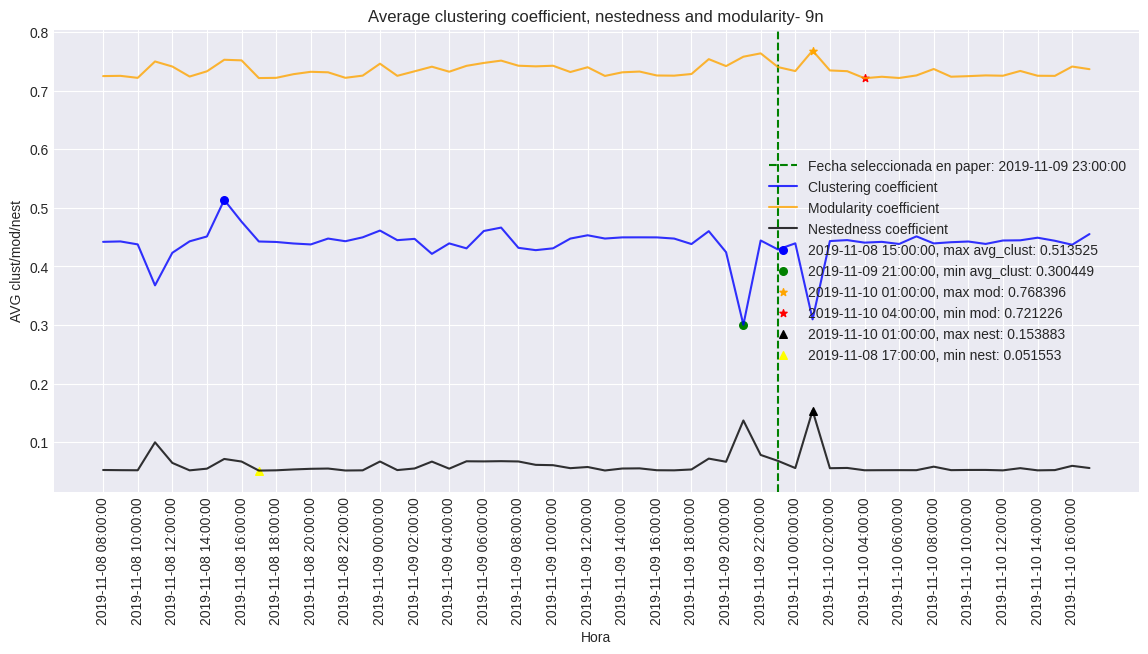

In [27]:
print(hour_sort)
if MANIFESTACION == "9n":
        fecha=str(int(437038))
        index_fecha=hour_sort.index(fecha)
        init=str(int(1573196400/3600))
        index_init=hour_sort.index(init)
        end=str(int(1573405200/3600))
        index_end=hour_sort.index(end)
else:
        fecha=str(int(429624))
        index_fecha=hour_sort.index(fecha)
        init=str(int(1546297200/3600))
        index_init=hour_sort.index(init)
        end=str(int(1546902000/3600))
        index_end=hour_sort.index(end)
print("Fecha identificada en paper para", MANIFESTACION, datetime.datetime.fromtimestamp(int(fecha)*3600))
print("Fecha inicial en paper", dt_sort_arr[index_init], ", fecha final en paper", dt_sort_arr[index_end])
plt.figure(figsize=(14,6)) 
plt.style.use('seaborn-v0_8-darkgrid')    

plt.axvline(x=dt_sort_arr[index_fecha], color="green", ls="--", label="Fecha seleccionada en paper: " + str(datetime.datetime.fromtimestamp(int(fecha)*3600)))


plt.plot(dt_sort_arr[index_init:index_end], clust_sort[index_init:index_end], alpha=0.8, c="blue", label="Clustering coefficient")
plt.plot(dt_sort_arr[index_init:index_end], mod_sort[index_init:index_end], alpha=0.8, c="orange", label="Modularity coefficient")
plt.plot(dt_sort_arr[index_init:index_end], nest_sort[index_init:index_end], alpha=0.8, c="black", label="Nestedness coefficient")

name_max_clust = str(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(max(clust_sort[index_init:index_end]))]) + ", max avg_clust: " + str(round(max(clust_sort[index_init:index_end]), 6))
name_min_clust  = str(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(min(clust_sort[index_init:index_end]))]) + ", min avg_clust: " + str(round(min(clust_sort[index_init:index_end]), 6))
plt.scatter(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(max(clust_sort[index_init:index_end]))], max(clust_sort[index_init:index_end]), s=30, c="blue", marker="o", label = name_max_clust)
plt.scatter(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(min(clust_sort[index_init:index_end]))], min(clust_sort[index_init:index_end]), s=30, c="green", marker="o", label = name_min_clust)

name_max_mod = str(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(max(mod_sort[index_init:index_end]))]) + ", max mod: " + str(round(max(mod_sort[index_init:index_end]), 6))
name_min_mod  = str(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(min(mod_sort[index_init:index_end]))]) + ", min mod: " + str(round(min(mod_sort[index_init:index_end]), 6))
plt.scatter(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(max(mod_sort[index_init:index_end]))], max(mod_sort[index_init:index_end]), s=30, c="orange", marker="*", label = name_max_mod)
plt.scatter(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(min(mod_sort[index_init:index_end]))], min(mod_sort[index_init:index_end]), s=30, c="red", marker="*", label = name_min_mod)
#plt.plot(points[0], points[1], alpha=alpha, label="K_T = " + str(arr_kt_plot[index]))

name_max_nest = str(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(max(nest_sort[index_init:index_end]))]) + ", max nest: " + str(round(max(nest_sort[index_init:index_end]), 6))
name_min_nest  = str(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(min(nest_sort[index_init:index_end]))]) + ", min nest: " + str(round(min(nest_sort[index_init:index_end]), 6))
plt.scatter(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(max(nest_sort[index_init:index_end]))], max(nest_sort[index_init:index_end]), s=30, c="black", marker="^", label = name_max_nest)
plt.scatter(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(min(nest_sort[index_init:index_end]))], min(nest_sort[index_init:index_end]), s=30, c="yellow", marker="^", label = name_min_nest)
   
plt.xlabel("Hora")
plt.ylabel("AVG clust/mod/nest")
plt.xticks(dt_sort_arr[index_init:index_end][::2], labels=dt_sort_arr[index_init:index_end][::2])
plt.xticks(rotation=90)
plt.title("Average clustering coefficient, nestedness and modularity- " + MANIFESTACION)
plt.legend()

plt.savefig("paper_avg_clust_mod_nest_" + MANIFESTACION)

plt.show()


In [25]:
dt_sort_arr[index_init]

datetime.datetime(2019, 11, 8, 8, 0)